<a href="https://colab.research.google.com/github/dani0047/driver_activity_recognition/blob/main/DAR_IC_ResNet50_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import all necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm import tqdm

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
#Select GPU as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(device))

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
folder_name = 'state_farm_kaggle'
folder_path = os.path.join('/content', folder_name)

os.makedirs(folder_path, exist_ok = True)

In [ ]:
drive_csv_path = '/content/drive/MyDrive/State Farm Kaggle Dataset/driver_imgs_list.csv'

colab_csv_path = '/content/state_farm_kaggle/driver_imgs_list.csv'

shutil.copy(drive_csv_path, colab_csv_path)

'/content/state_farm_kaggle/driver_imgs_list.csv'

In [ ]:
import zipfile

file_dir = '/content/state_farm_kaggle'
target_folder = 'train_split'

#Upload train data folder to google colab files directory
if not os.path.exists(os.path.join (file_dir, target_folder)):
  zip_train= zipfile.ZipFile('/content/drive/MyDrive/State Farm Kaggle Dataset/train_split.zip', 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [ ]:
df = pd.read_csv('/content/state_farm_kaggle/driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df.shape

(22424, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [ ]:
train_dir = os.path.join(file_dir,'train_split/train')
test_dir = os.path.join(file_dir,'train_split/val')

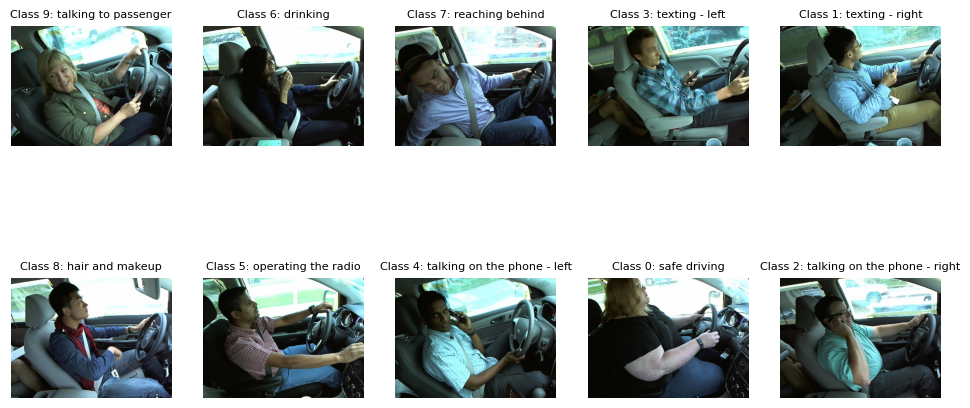

In [ ]:
state = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger', 'UNKNOWN']

torch.manual_seed(42)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, class_name in enumerate(os.listdir(train_dir)):
  class_idx = int(list(class_name)[1])
  class_path = os.path.join(train_dir, class_name)
  images = [img for img in os.listdir(class_path)]
  random_index = np.random.randint(len(images))
  image_path = os.path.join(class_path, images[random_index])
  image = mpimg.imread(image_path)


  row = i // 5  # Determine the row in the grid
  col = i % 5   # Determine the column in the grid
  ax = axs[row, col]  # Select the current subplot
  ax.imshow(image)
  ax.axis('off')
  ax.set_title(f'Class {class_idx}: {state[class_idx]}', fontdict={'fontsize': 8, 'fontweight': 'medium'})


In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (244,244)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
}

In [ ]:
train_dataset = datasets.ImageFolder(root = train_dir, transform = data_transforms['train'],  target_transform = None)
test_dataset = datasets.ImageFolder(root = test_dir, transform = data_transforms['valid'],  target_transform = None)


In [ ]:
num_classes = len(train_dataset.classes)
batch_size = 32

In [ ]:
#Create a data loader with batches
train_load = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_load))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 244, 244]), torch.Size([32]))

In [ ]:
pretrained_model = None

if pretrained_model == None:
  model = Model.resnet50(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False  # Freeze pre-trained layers



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   False
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    └─

In [ ]:
#Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = num_classes
num_features = model.fc.in_features

# Recreate the classifier layer and seed it to the target device
model.fc= nn.Sequential(
    nn.Linear(num_features, output_shape)
).to(device)


In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
criterion= nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs = 5):
# def train_model(model, criterion, optimizer, epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially

    for epoch in tqdm(range(epochs)):
      train_time_start_on_cpu = timer()
      since = time.time()
      print(f"\nEpoch: {epoch}\n-------")
      ### Training
      train_loss, train_acc = 0, 0
      model.train()
      for batch, (X_train, y_train) in enumerate(train_load):
        model.train()
        # 1. Forward pass
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()

        train_pred = model(X_train)
        loss = criterion(train_pred, y_train)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y_train, y_pred=train_pred.argmax(dim=1))

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
          print(f"Looked at {batch * len(X_train)}/{len(train_load.dataset)} samples")

      # Divide total train loss by length of train dataloader (average loss per batch per epoch)
      train_loss /= len(train_load)

      # Divide total accuracy by length of test dataloader (per batch)
      train_acc /= len(train_load)

      epoch_duration = time.time()-since
      losses.append(train_loss)
      accuracies.append(train_acc)

      ### Testing
      # Setup variables for accumulatively adding up loss and accuracy
      test_acc = 0
      model.eval()
      with torch.inference_mode():
        for X_test, y_test in test_load:
          # 1. Forward pass
          X_test = X_test.to(device)
          y_test = y_test.to(device)
          test_pred = model(X_test)

          # 3. Calculate accuracy (preds need to be same as y_true)
          test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_load)
        test_accuracies.append(test_acc)
      scheduler.step(test_acc)
      ## Print out what's happening
      print(f"\nEpoch {epoch} duration: {epoch_duration:.0f}s, Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test acc: {test_acc:.2f}%\n")

    # Calculate training time
    train_time_end_on_cpu = timer()
    total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                                end=train_time_end_on_cpu,
                                                device=str(next(model.parameters()).device))
    print("Finished Training")
    return model, losses, accuracies, test_accuracies



In [ ]:
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, epochs=10)
# model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 10%|█         | 1/10 [02:19<20:59, 139.94s/it]


Epoch 0 duration: 114s, Train loss: 1.35079, Train acc: 65.26% | Test acc: 75.11%


Epoch: 1
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 20%|██        | 2/10 [04:40<18:42, 140.25s/it]


Epoch 1 duration: 115s, Train loss: 0.93036, Train acc: 77.23% | Test acc: 81.76%


Epoch: 2
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 30%|███       | 3/10 [06:59<16:19, 139.86s/it]


Epoch 2 duration: 113s, Train loss: 0.76218, Train acc: 81.30% | Test acc: 83.75%


Epoch: 3
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 40%|████      | 4/10 [09:18<13:56, 139.42s/it]


Epoch 3 duration: 113s, Train loss: 0.67643, Train acc: 83.22% | Test acc: 85.77%


Epoch: 4
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 50%|█████     | 5/10 [11:37<11:35, 139.12s/it]


Epoch 4 duration: 113s, Train loss: 0.60726, Train acc: 84.78% | Test acc: 87.79%


Epoch: 5
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 60%|██████    | 6/10 [13:57<09:17, 139.38s/it]


Epoch 5 duration: 114s, Train loss: 0.57597, Train acc: 85.61% | Test acc: 87.79%


Epoch: 6
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 70%|███████   | 7/10 [16:16<06:58, 139.45s/it]


Epoch 6 duration: 114s, Train loss: 0.57822, Train acc: 85.33% | Test acc: 87.50%


Epoch: 7
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 80%|████████  | 8/10 [18:35<04:38, 139.43s/it]


Epoch 7 duration: 113s, Train loss: 0.57273, Train acc: 85.59% | Test acc: 87.92%


Epoch: 8
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


 90%|█████████ | 9/10 [20:55<02:19, 139.48s/it]


Epoch 8 duration: 114s, Train loss: 0.55887, Train acc: 86.09% | Test acc: 88.61%


Epoch: 9
-------
Looked at 0/17943 samples
Looked at 3200/17943 samples
Looked at 6400/17943 samples
Looked at 9600/17943 samples
Looked at 12800/17943 samples
Looked at 16000/17943 samples


100%|██████████| 10/10 [23:14<00:00, 139.48s/it]


Epoch 9 duration: 114s, Train loss: 0.55260, Train acc: 86.46% | Test acc: 88.65%

Train time on cuda:0: 139.178 seconds
Finished Training


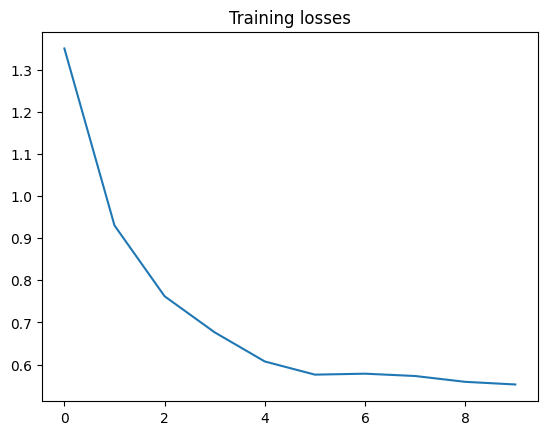

In [ ]:
training_losses_cpu = [loss.detach().cpu().numpy() for loss in training_losses]
plt.title('Training losses')
plt.plot(training_losses_cpu)
plt.show()

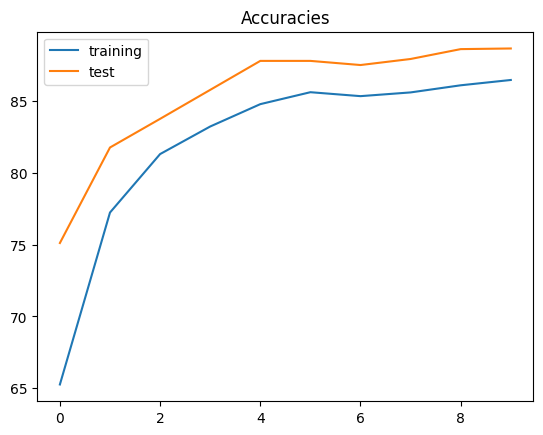

In [ ]:
plt.title('Accuracies')
plt.plot(training_accs, label = 'training')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/State Farm Kaggle Dataset/model_param/epoch_10/resnet50'

torch.save(model.state_dict(), model_path)